In [34]:
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import nrrd
import os


# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/mnt/data/csh_data/emlddmm/emlddmm.py'>

In [35]:
# This example was prepared for Ricardo Coronado Leija at NYU
# An issue is that atlas and target images are in different units
# this isn't supported in command line interface yet
# atlas is 40,40,112
# target is 0.35 0.35 0.7 -> 350x350x700 micron
# new version skullstripped from ricardo
# target is

In [36]:
# the scales I will use are
# high res
# atlas 
# 16 16 6
# target
# 2 2 1
#
# low res
# target
# 4 4 2
# atlas
# 32 32 12

In [37]:
atlas_name = '/home/dtward/data/csh_data/marmoset/Woodward_2018/bma-1-mri-reorient.vtk'
label_name = '/home/dtward/data/csh_data/marmoset/Woodward_2018/bma-1-region_seg-reorient.vtk'
target_name = '/mnt/data/csh_data/ricardo/dki_b0.nii'
target_name = '/mnt/data/csh_data/ricardo/t2_pad_skull_bse.nii'

targets_to_transform_names = ['/mnt/data/csh_data/ricardo/dki_b0.nii',
                              '/mnt/data/csh_data/ricardo/dki_fa.nii',
                              '/mnt/data/csh_data/ricardo/t2_r1_n1.nii']
config_file = 'ricardo_test.json'
output_dir = 'ricardo_nii_test/'
output_image_format = '.nii'
target_voxel_scale_factor = 1000 # convert mm to micron

In [38]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

Found extension .vtk
[ 39.999999  39.999999 112.000003]


<IPython.core.display.Javascript object>


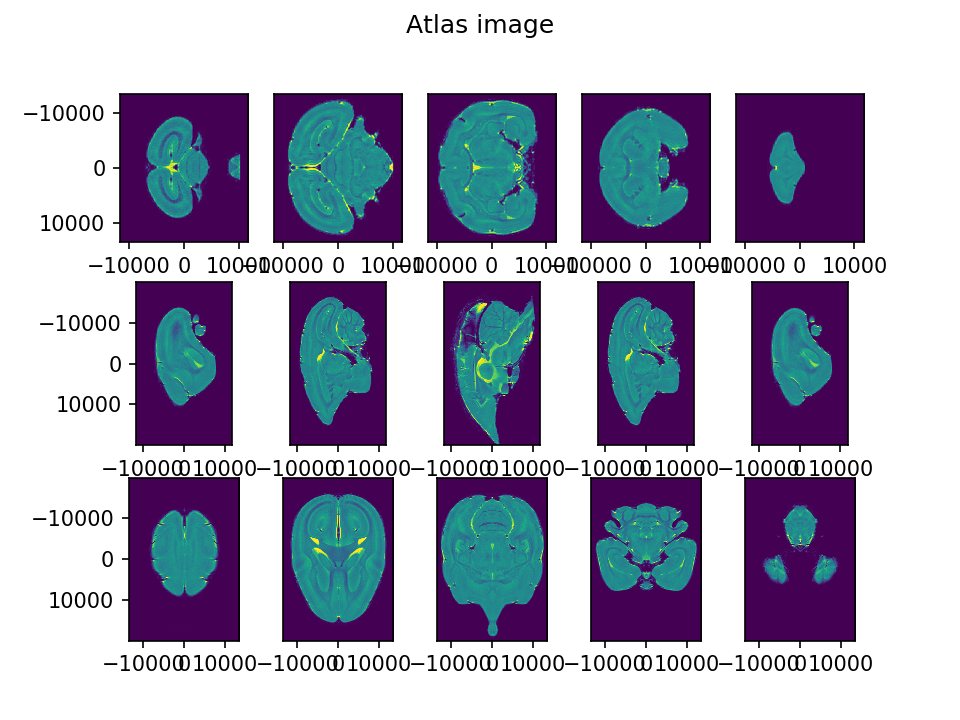

Text(0.5, 0.98, 'Atlas image')

In [39]:
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')

<IPython.core.display.Javascript object>


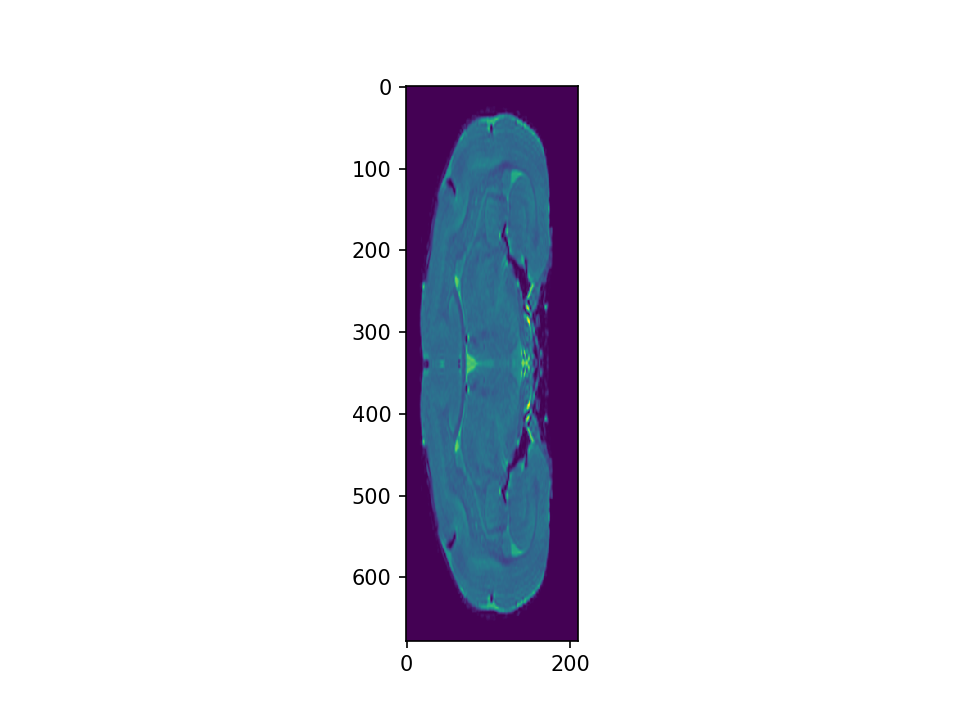

In [42]:
f,ax = plt.subplots()
ax.imshow(I[0,I.shape[1]//2])

In [31]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[639.9999840000055, 639.9999839999982, 672.0000180000025]


<IPython.core.display.Javascript object>


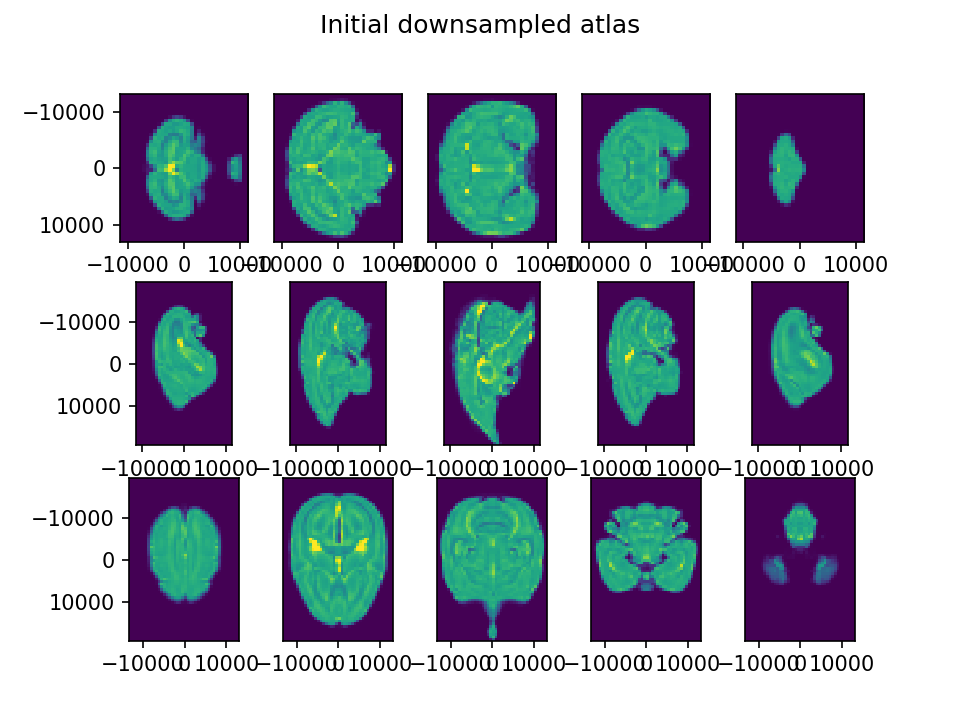

In [32]:
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Initial downsampled atlas')
fig[0].canvas.draw()

Found extension .nii
Opening with nibabel, note only 3D images supported
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 188 188  58   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.         0.26966292 0.26966292 0.5395833  1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0027268599
quatern_c       : 0.0

<IPython.core.display.Javascript object>


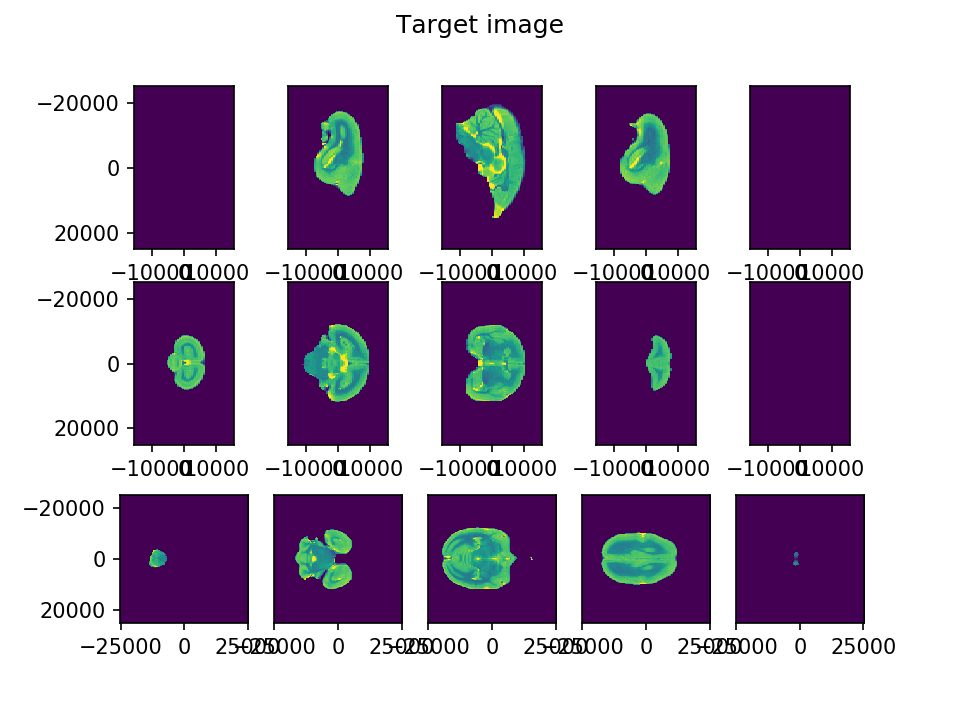

In [33]:
# target
imp.reload(emlddmm)
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
xJ = [x*target_voxel_scale_factor for x in xJ]
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
fig[0].canvas.draw()
W0 = np.ones_like(J[0])


In [10]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
print(dJ)
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

[539.3258333206177, 539.3258333206177, 539.5833253860474]


<IPython.core.display.Javascript object>


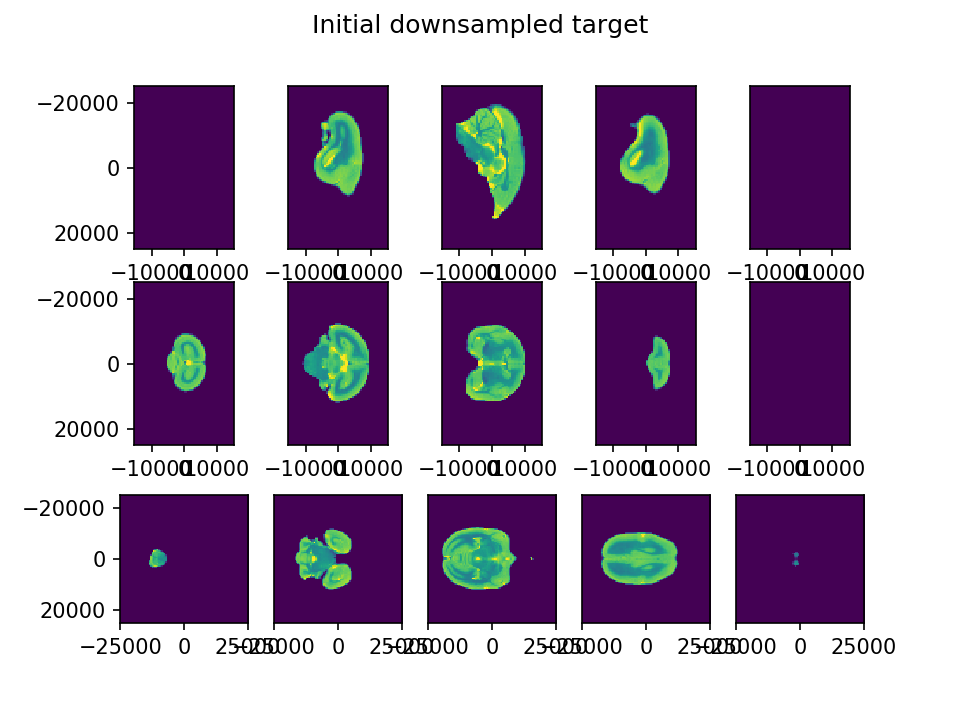

<IPython.core.display.Javascript object>


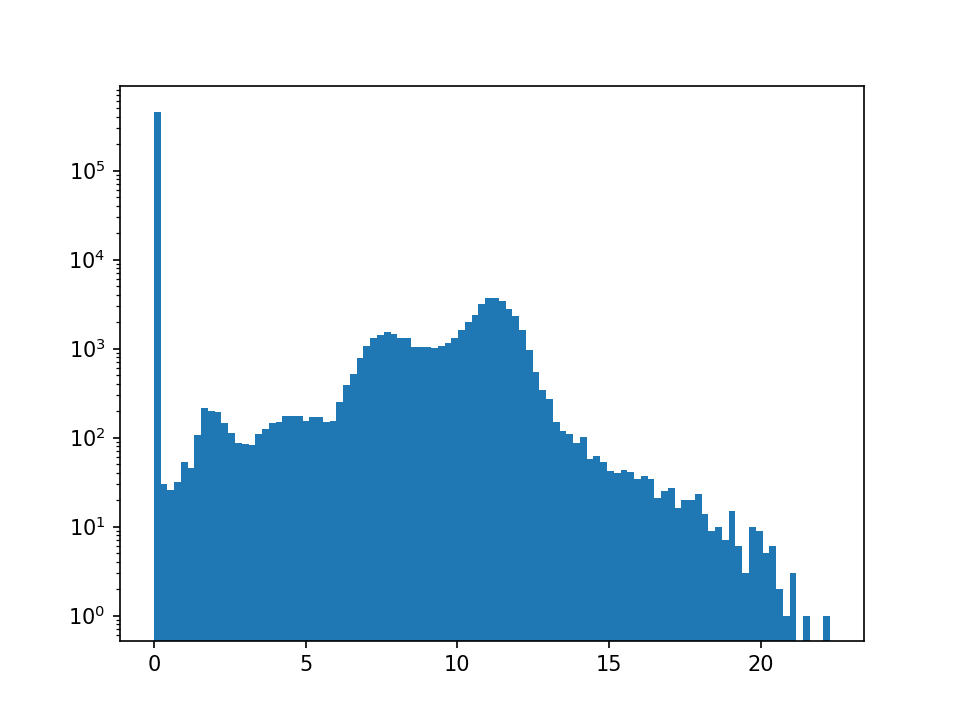

(array([4.60036e+05, 3.00000e+01, 2.60000e+01, 3.20000e+01, 5.30000e+01,
        4.50000e+01, 1.08000e+02, 2.16000e+02, 1.98000e+02, 1.92000e+02,
        1.45000e+02, 1.14000e+02, 8.70000e+01, 8.50000e+01, 8.30000e+01,
        1.11000e+02, 1.26000e+02, 1.45000e+02, 1.50000e+02, 1.76000e+02,
        1.73000e+02, 1.76000e+02, 1.53000e+02, 1.72000e+02, 1.71000e+02,
        1.49000e+02, 1.53000e+02, 2.51000e+02, 3.93000e+02, 5.25000e+02,
        7.85000e+02, 1.08100e+03, 1.31000e+03, 1.42400e+03, 1.52000e+03,
        1.44900e+03, 1.31900e+03, 1.30100e+03, 1.04200e+03, 1.05400e+03,
        1.04600e+03, 1.02400e+03, 1.06900e+03, 1.17000e+03, 1.31300e+03,
        1.60100e+03, 1.96800e+03, 2.39600e+03, 3.18300e+03, 3.69500e+03,
        3.73700e+03, 3.44000e+03, 2.76100e+03, 2.33300e+03, 1.61300e+03,
        9.59000e+02, 5.44000e+02, 3.40000e+02, 2.72000e+02, 1.49000e+02,
        1.20000e+02, 1.09000e+02, 8.80000e+01, 1.02000e+02, 5.70000e+01,
        6.20000e+01, 5.30000e+01, 4.20000e+01, 4.00

In [11]:
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Initial downsampled target')
fig[0].canvas.draw()
fig,ax = plt.subplots()
ax.hist(J.ravel(),bins=100,log=True)

[[[ 0.  1.  0.  0.]
  [ 1.  0.  0.  0.]
  [ 0.  0. -1.  0.]
  [ 0.  0.  0.  1.]]]


<IPython.core.display.Javascript object>


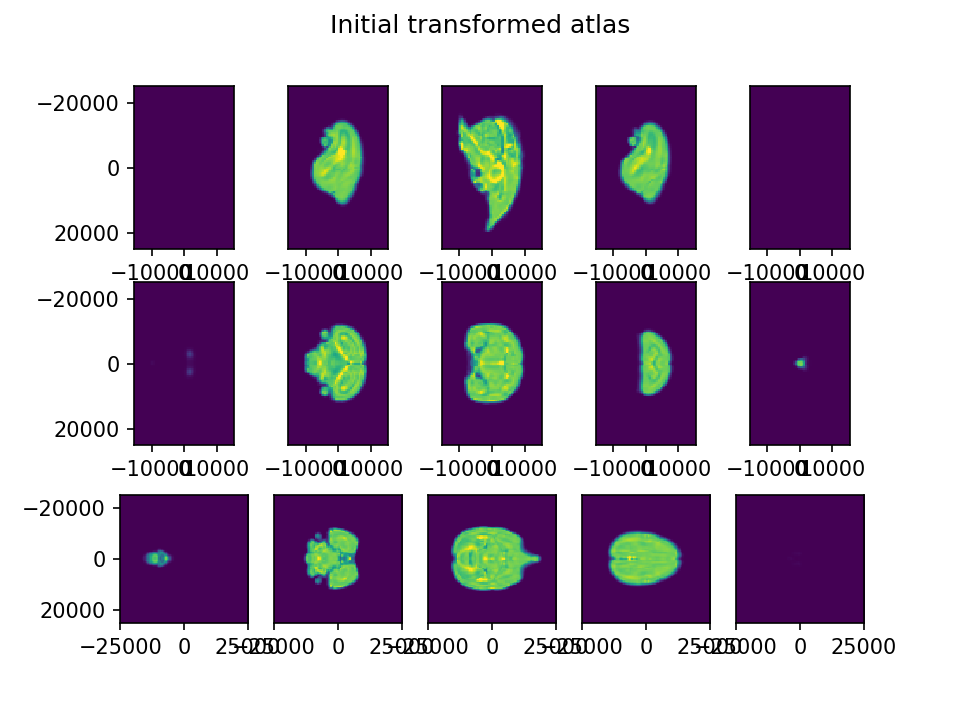

Text(0.5, 0.98, 'Initial transformed atlas')

In [12]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)
# this affine (below) is stored in config
#A = np.array([[0,1.0,0.0,0.0],[1.0,0.0,0.0,0.0],[0.0,0.0,-1.0,0.0],[0.0,0.0,0.0,1.0]])
print(A)

# this affine matrix should be 4x4, but it may be 1x4x4
while A.ndim > 2:
    A = A[0]
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')

Found 2 scales
dv tensor([1920., 1920., 2016.], device='cuda:0')
a scale is 3840.0


<IPython.core.display.Javascript object>


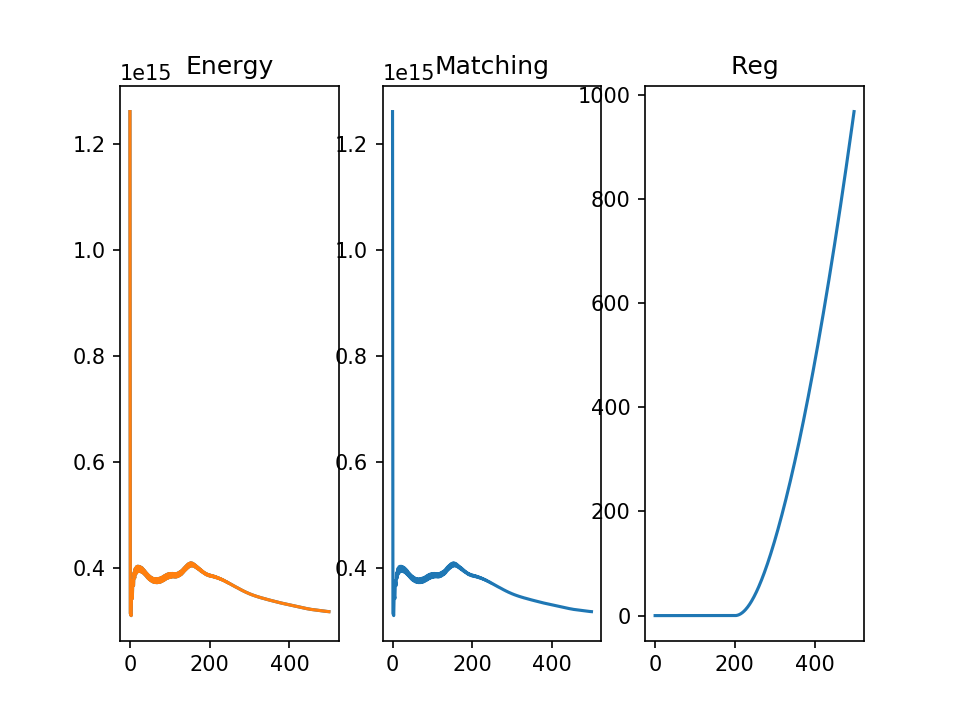

<IPython.core.display.Javascript object>


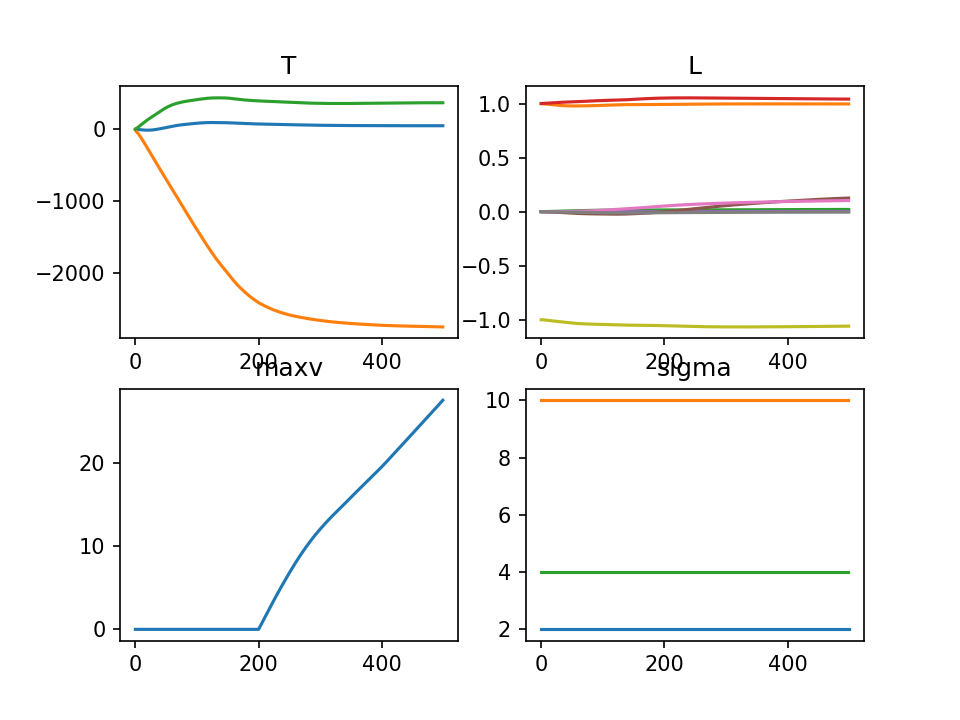

<IPython.core.display.Javascript object>


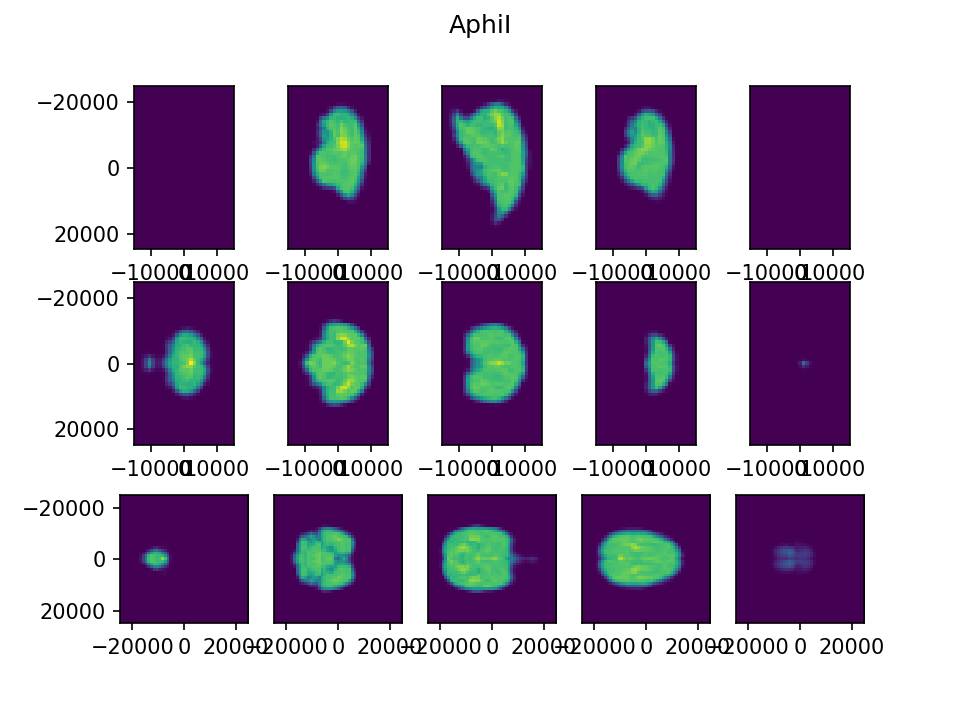

<IPython.core.display.Javascript object>


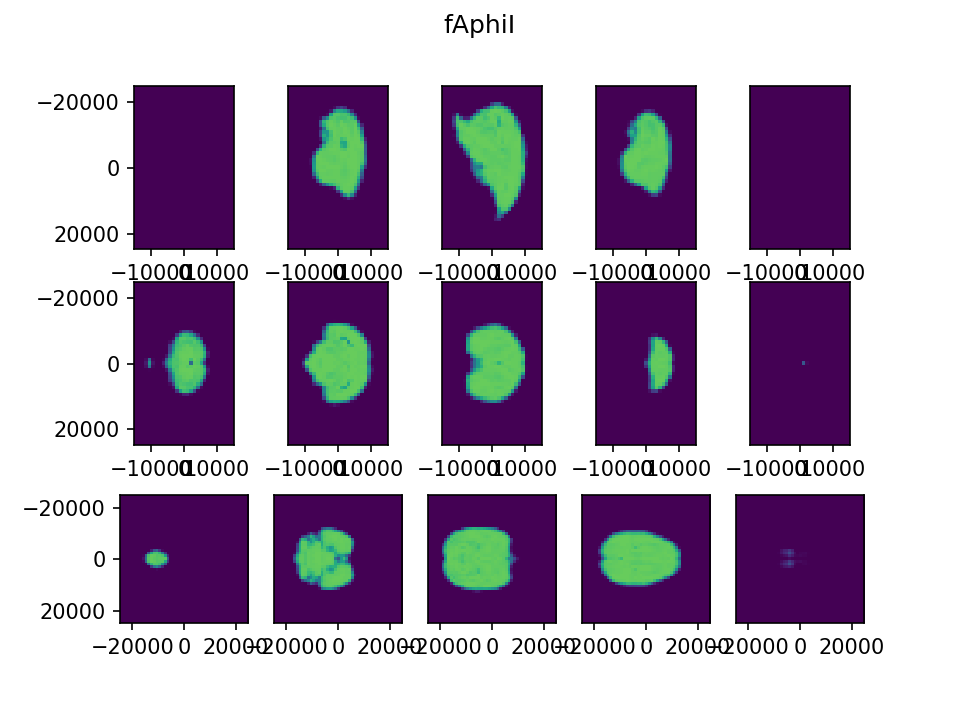

<IPython.core.display.Javascript object>


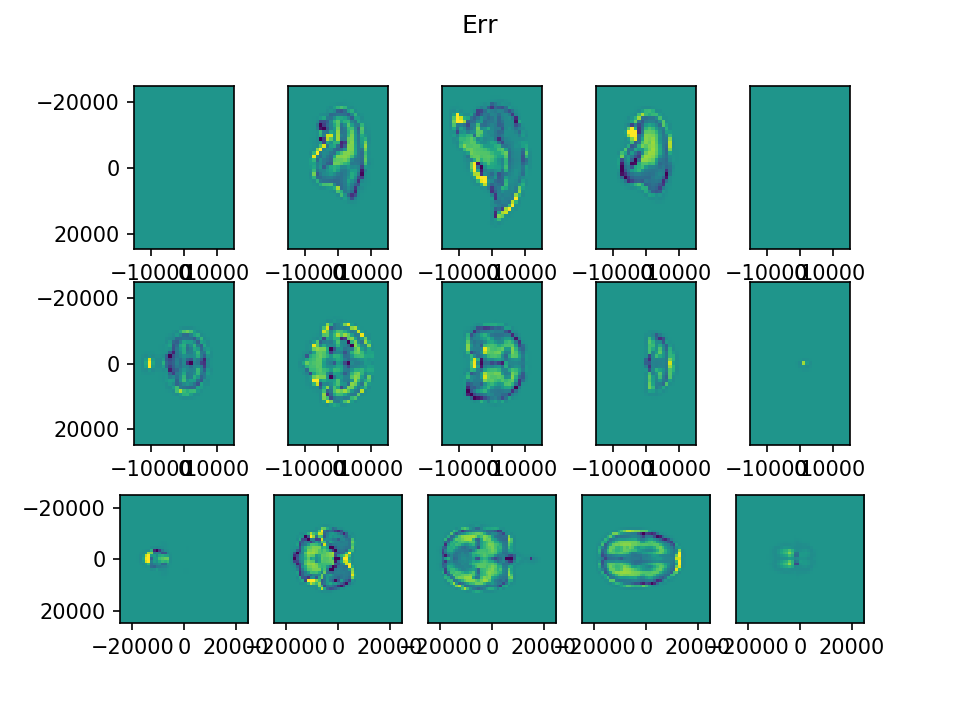

<IPython.core.display.Javascript object>


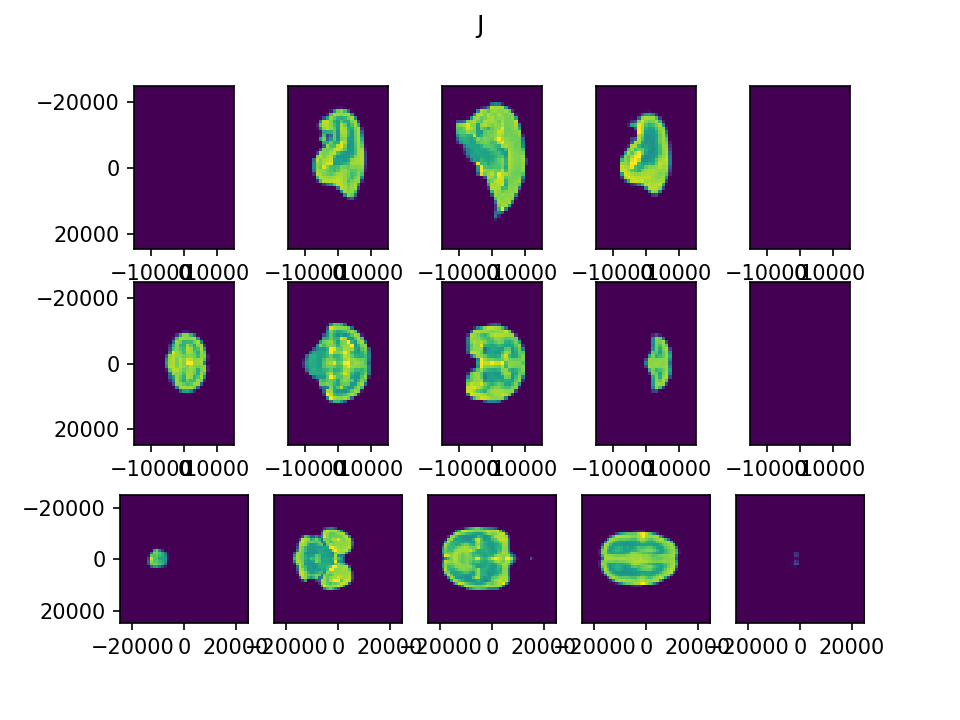

<IPython.core.display.Javascript object>


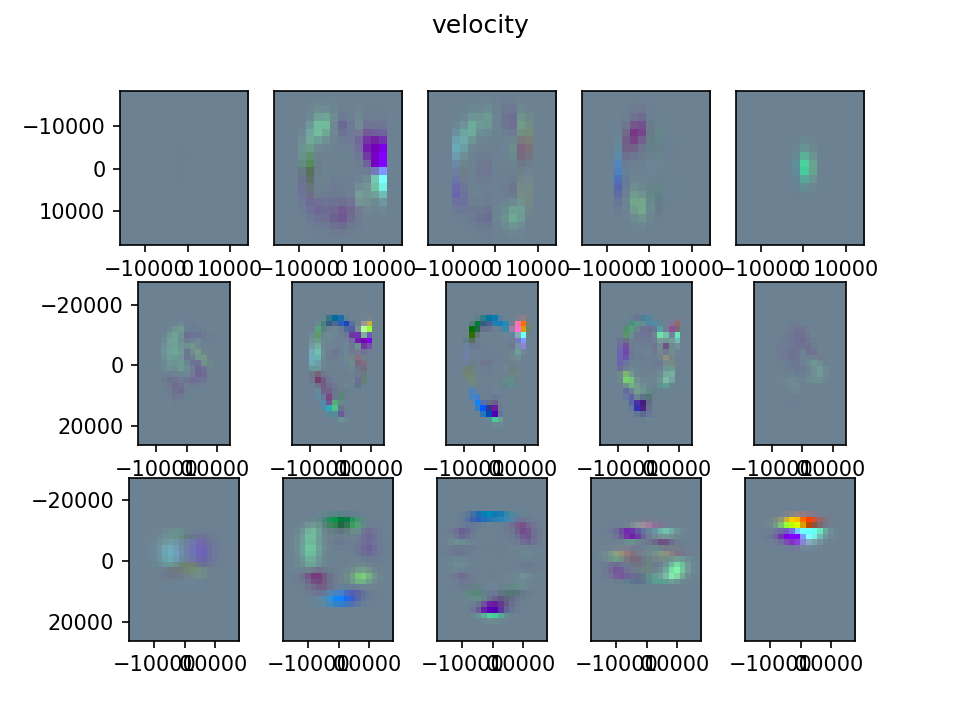

<IPython.core.display.Javascript object>


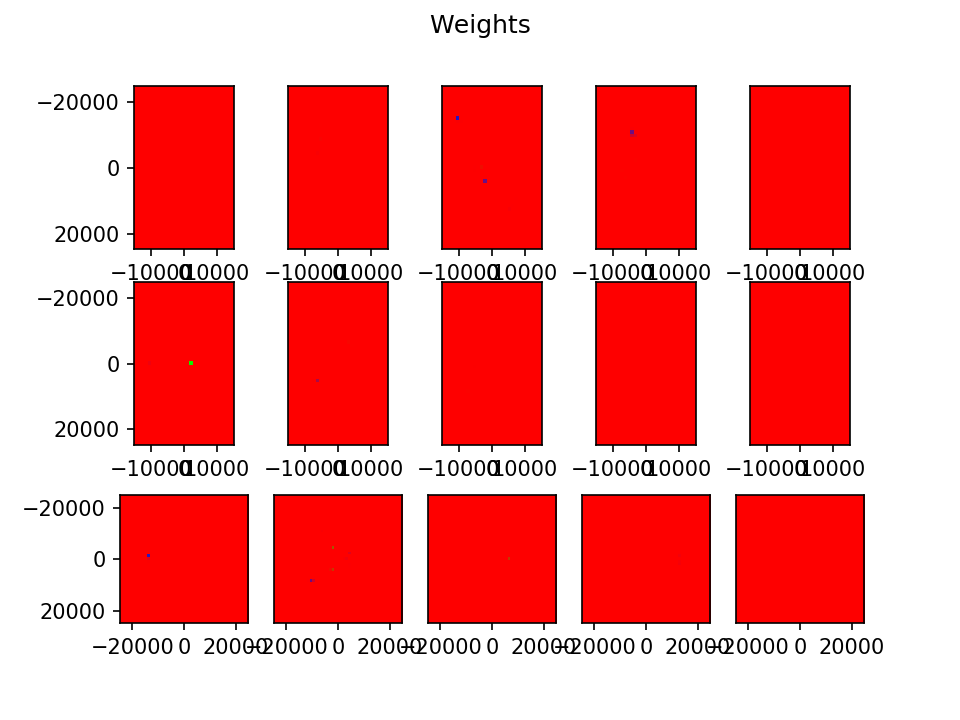

/mnt/data/csh_data/emlddmm/emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Iteration 130, linear oscilating, reducing eA to 90000.0
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190
Iteration 200, linear oscilating, reducing eA to 81000.0
Finished iteration 200
Finished iteration 210
Finished iteration 220
Finished iteration 230
Finished iteration 240
Finished iteration 250
Finished iteration 260
Finished iteration 270
Finished iteration 280
Finished iteration 290
Finished iteration 300
Finished iteration 310
Finished iteration 320
Finished iteration 330
Finished iteration 340
Finished iteration 350
Finished iteration 360
Finished iteration 370
Finished iteration 380


<IPython.core.display.Javascript object>


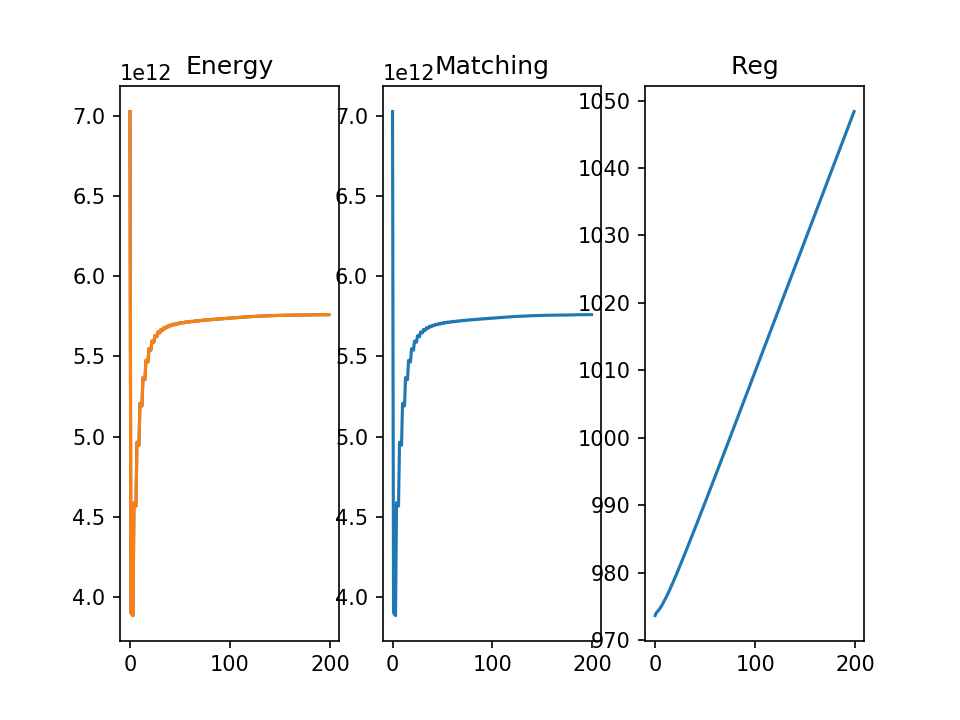

<IPython.core.display.Javascript object>


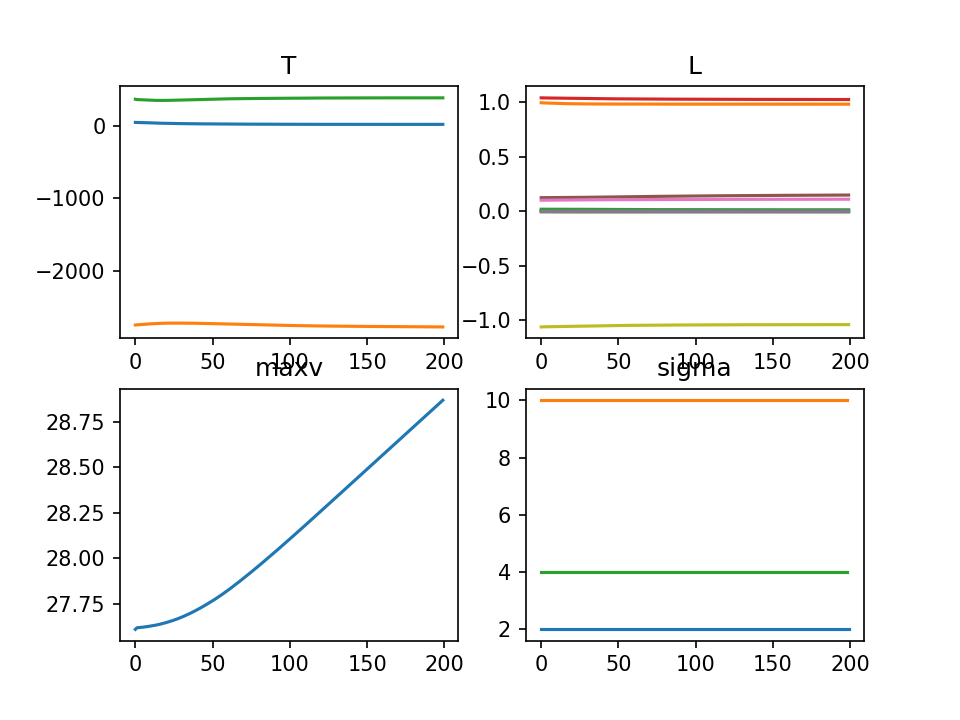

<IPython.core.display.Javascript object>


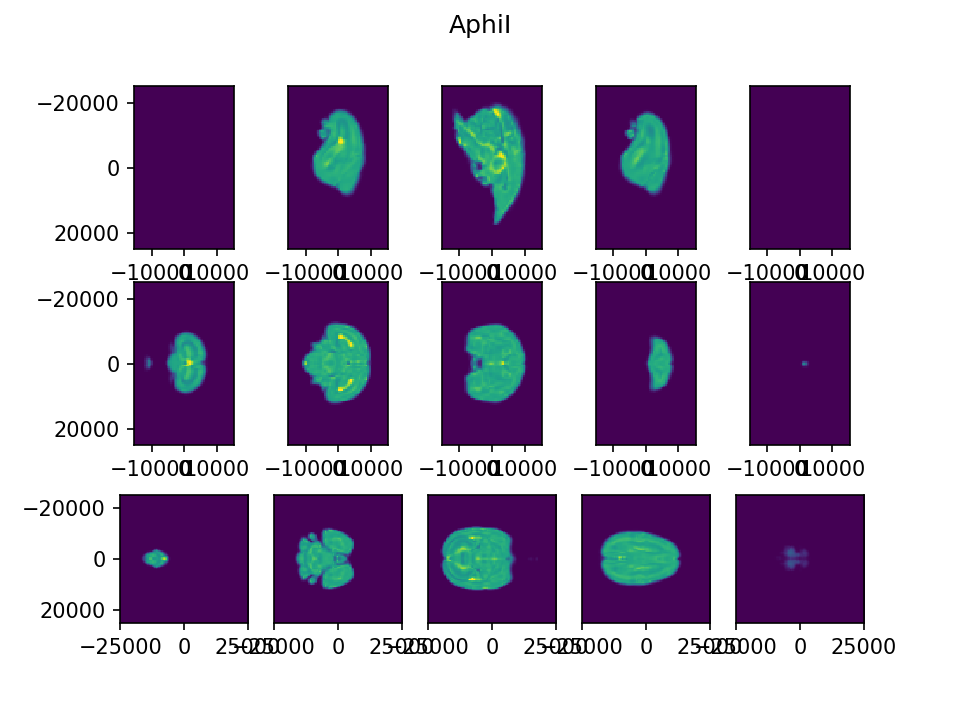

<IPython.core.display.Javascript object>


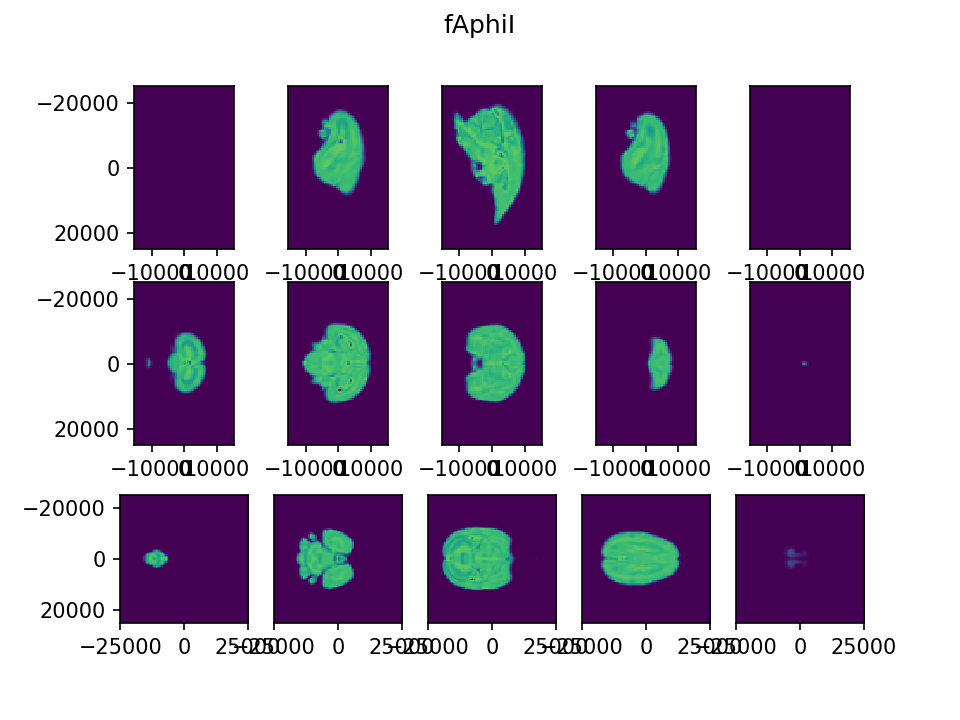

<IPython.core.display.Javascript object>


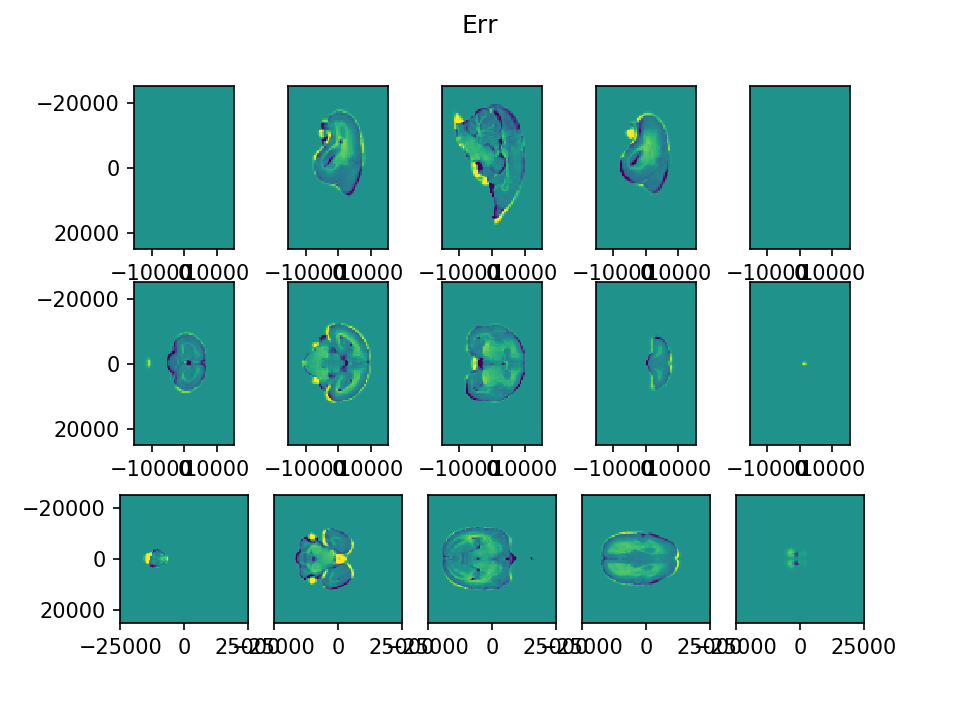

<IPython.core.display.Javascript object>


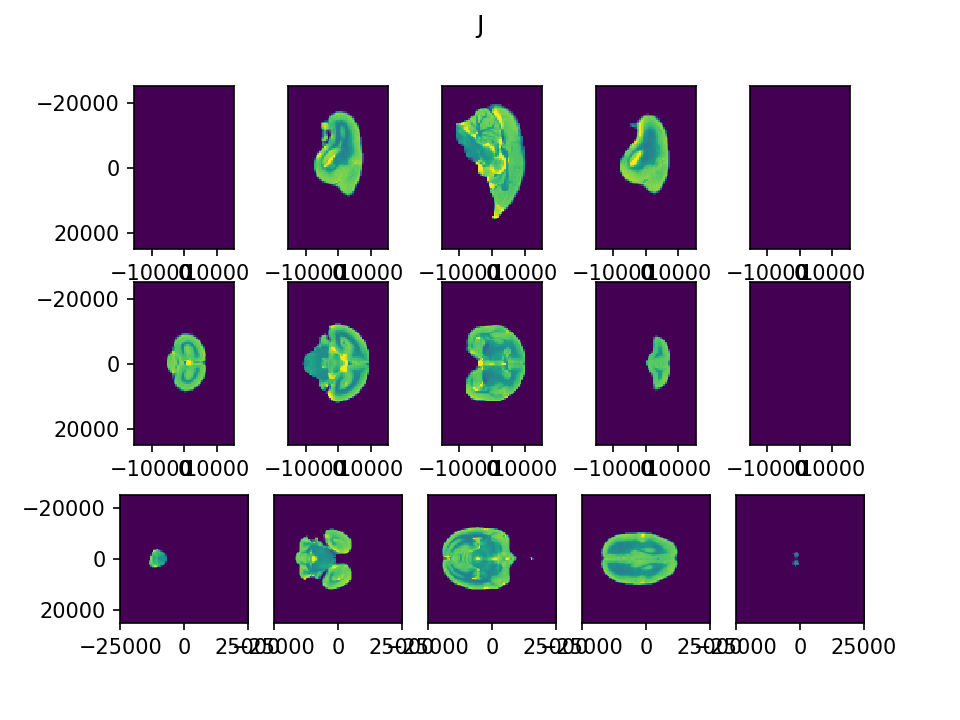

/mnt/data/csh_data/emlddmm/emlddmm.py:873: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figV = plt.figure()


<IPython.core.display.Javascript object>


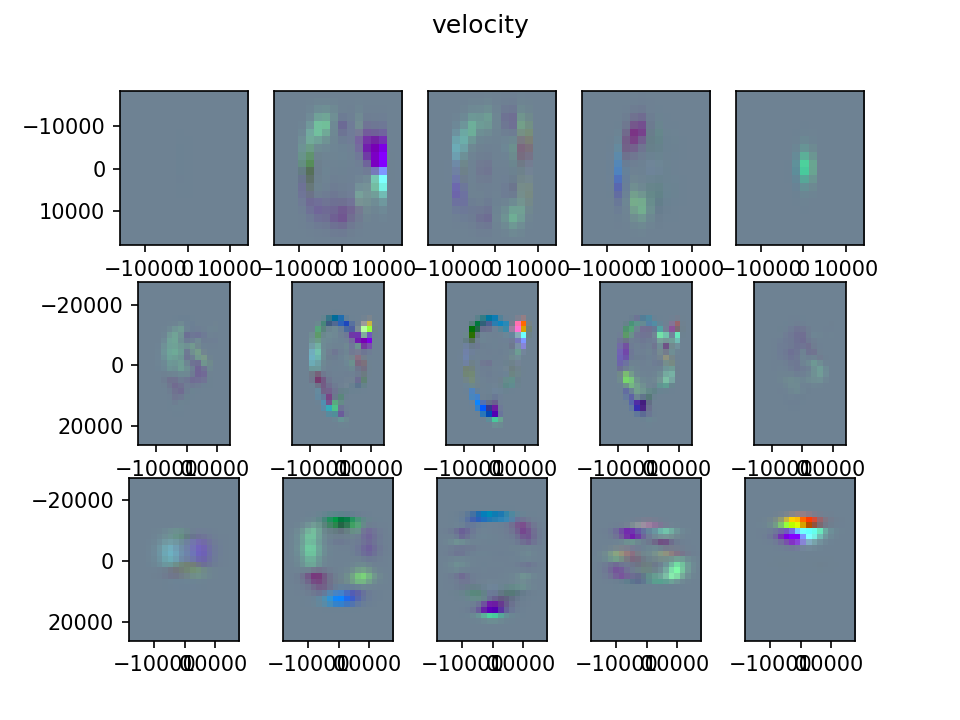

/mnt/data/csh_data/emlddmm/emlddmm.py:874: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figW = plt.figure()


<IPython.core.display.Javascript object>


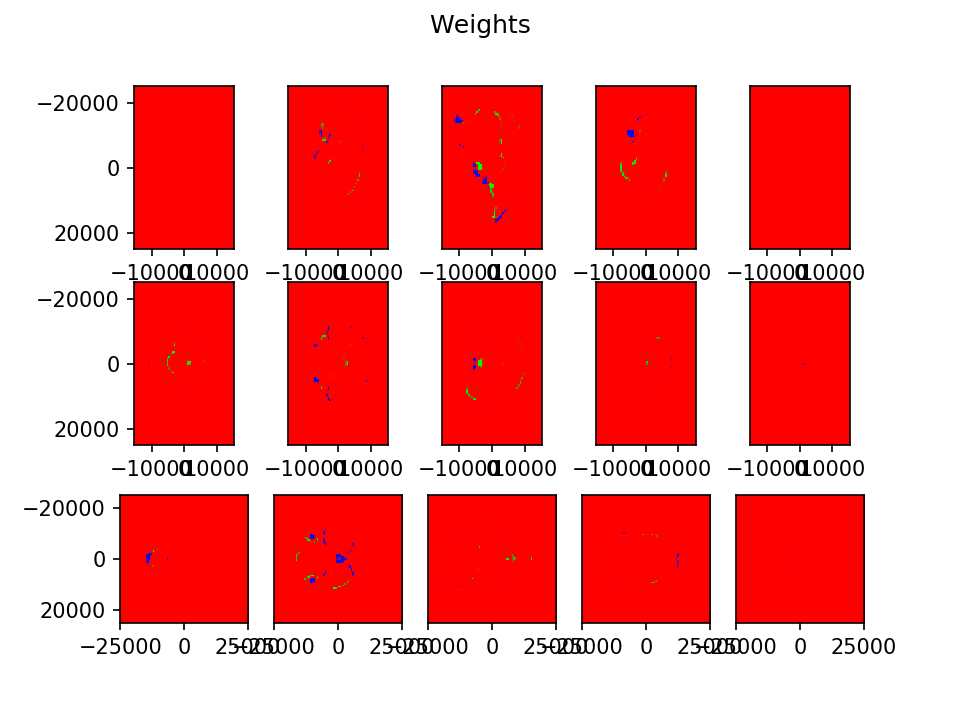

Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Iteration 180, translation oscilating, reducing eA to 90000.0
Finished iteration 180
Finished iteration 190


In [13]:
device = 'cuda:0'
#device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [14]:
imp.reload(emlddmm)
emlddmm.write_transform_outputs(output_dir,output[-1])

In [15]:
# get labels
xS,S,title,names = emlddmm.read_data(label_name,endian='l')

Found extension .vtk


cpu
output dir is ricardo_nii_test/qc/


/mnt/data/csh_data/emlddmm/emlddmm.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


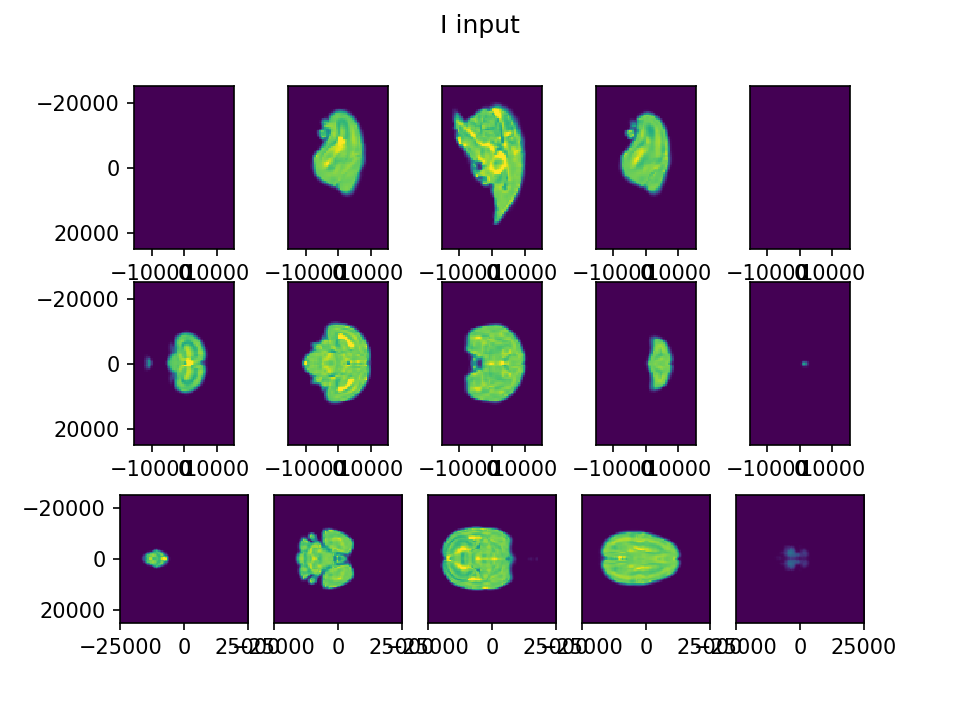

4294967296 4294967296


<IPython.core.display.Javascript object>


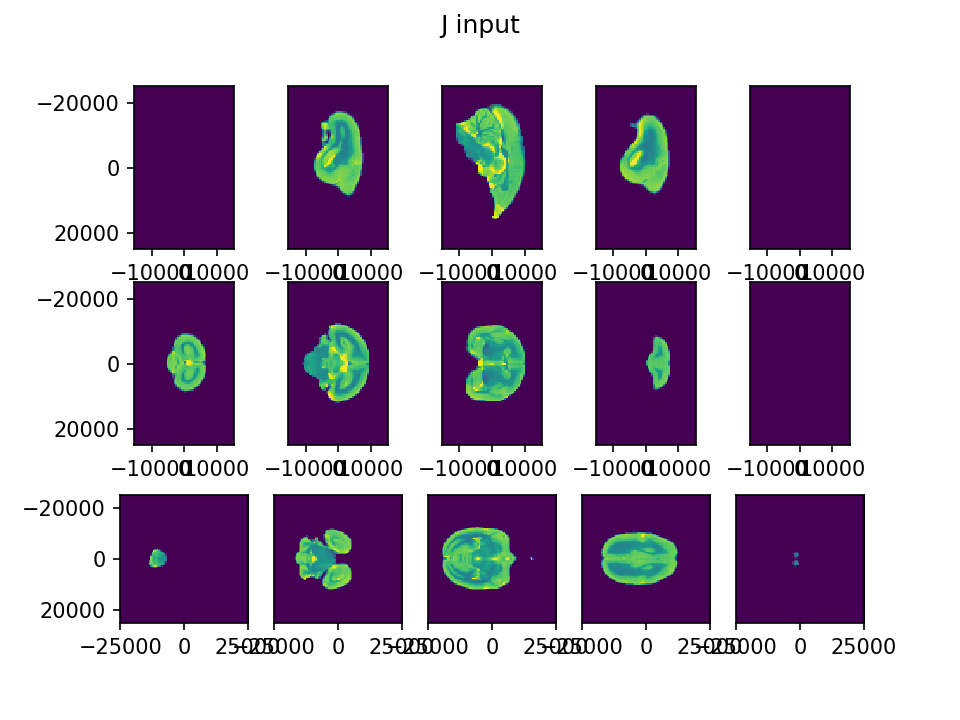

4294967296 4294967296


<IPython.core.display.Javascript object>


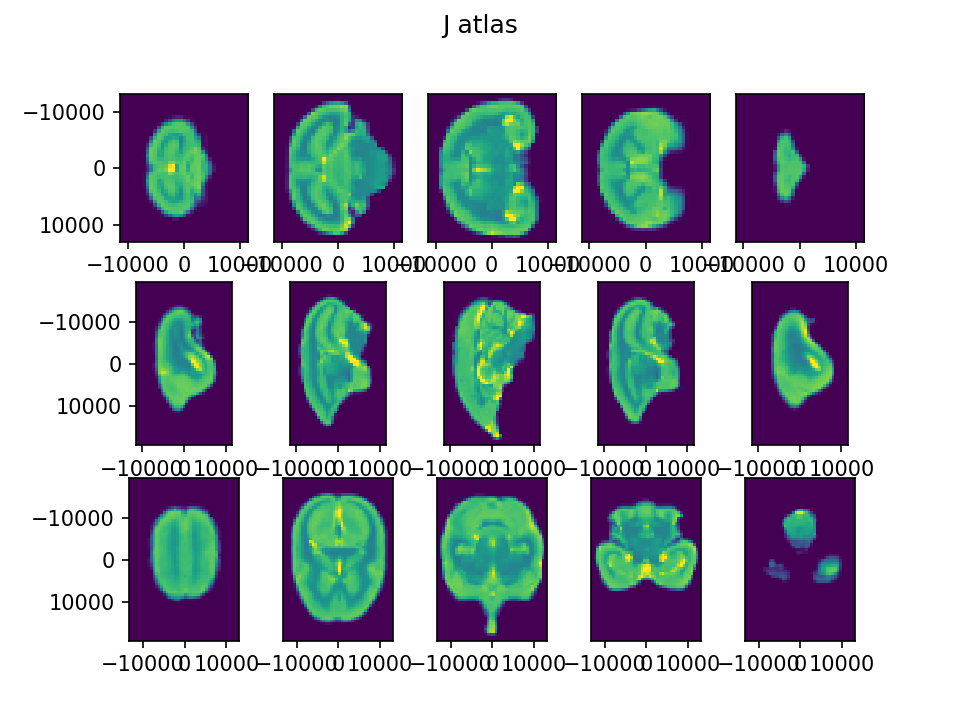

4294967296 4294967296


<IPython.core.display.Javascript object>


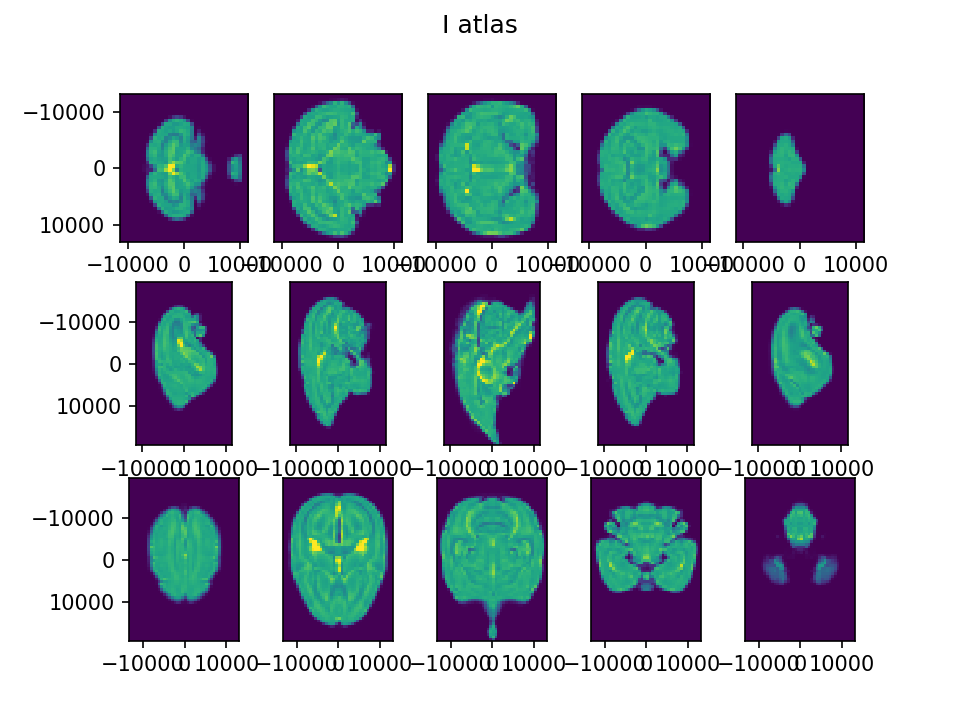

4294967296 4294967296


In [16]:
imp.reload(emlddmm)
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J,xS=xS,S=S.astype(float))

In [17]:
# apply forward transform (target image to atlas)
imp.reload(emlddmm)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

starting to compose sequence with transforms ricardo_nii_test/


<IPython.core.display.Javascript object>


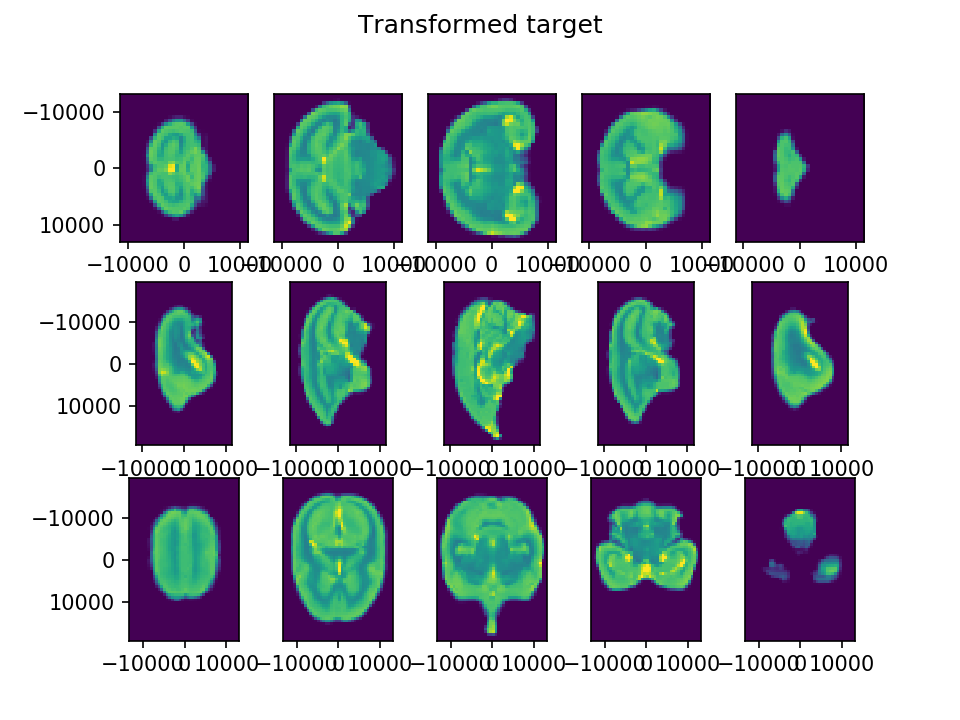

In [18]:
fig = emlddmm.draw(Jt,xI)
fig[0].suptitle('Transformed target')
fig[0].canvas.draw()

In [19]:
# apply backward transform (atlas images to target)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xJ]))
Xout = emlddmm.compose_sequence(output_dir,Xin,direction='b')
It = emlddmm.apply_transform_float(xI,I,Xout)
St = emlddmm.apply_transform_int(xS,S,Xout)

starting to compose sequence with transforms ricardo_nii_test/


<IPython.core.display.Javascript object>


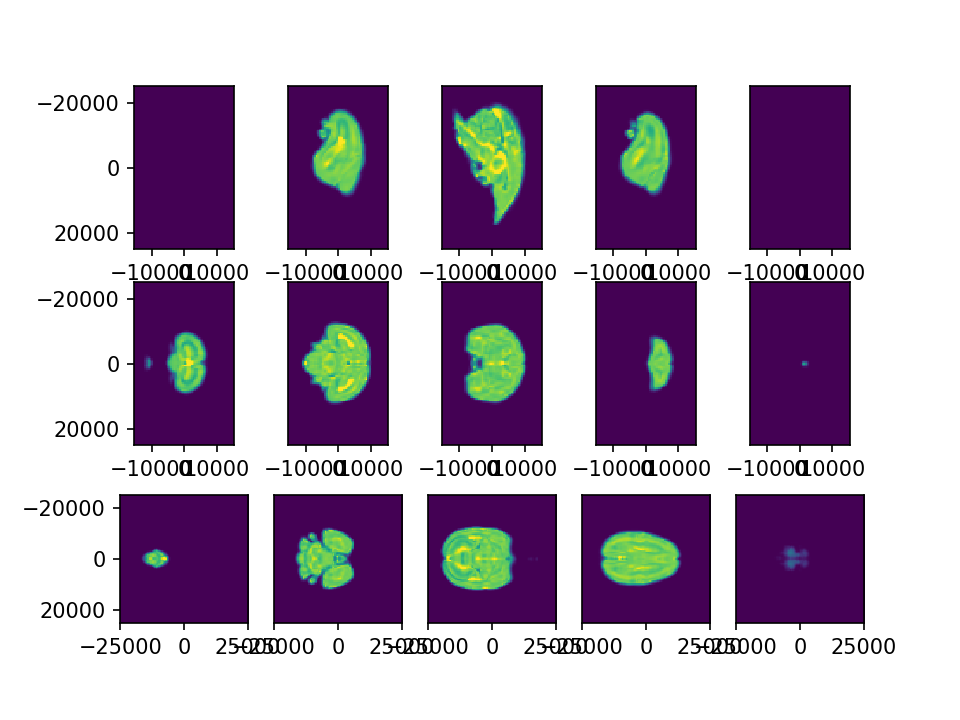

<IPython.core.display.Javascript object>


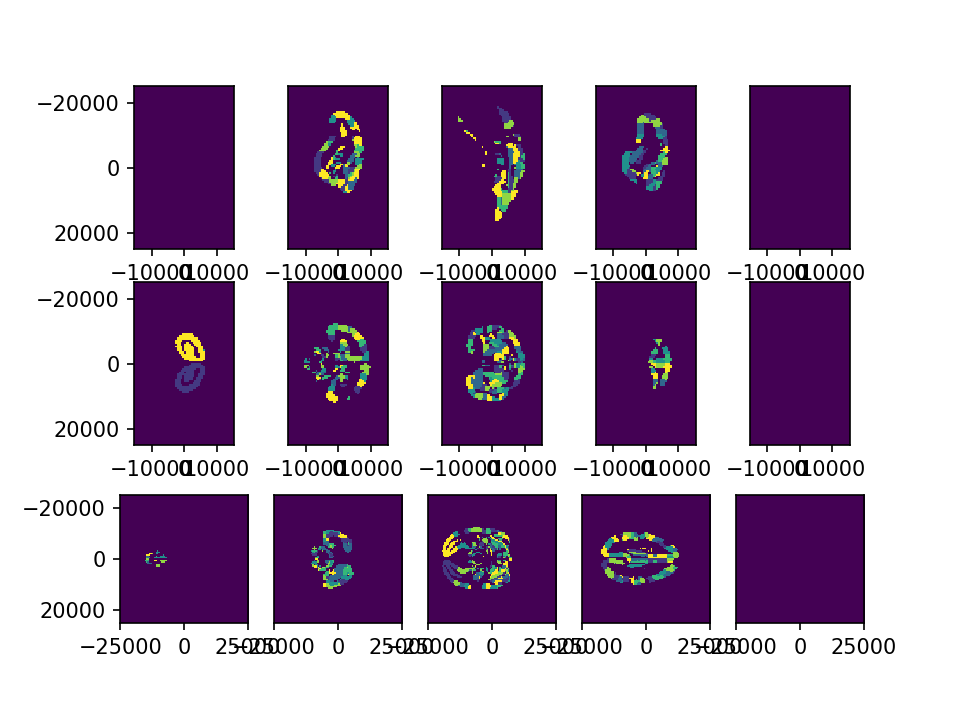

In [20]:
fig = emlddmm.draw(It,xJ)
fig[0].canvas.draw()
fig = emlddmm.draw(St%7,xJ)
fig[0].canvas.draw()

In [21]:
atlas_output_dir = os.path.join(output_dir,'to_atlas')
if not os.path.isdir(atlas_output_dir): os.mkdir(atlas_output_dir)
target_output_dir = os.path.join(output_dir,'to_target')
if not os.path.isdir(target_output_dir): os.mkdir(target_output_dir)

In [22]:
# write transformed images, these are at low res
imp.reload(emlddmm)
ext = output_image_format
if ext[0] != '.': ext = '.' + ext
imp.reload(emlddmm)
emlddmm.write_data(os.path.join(atlas_output_dir,'target_to_atlas'+ext),xI,Jt,'target_to_atlas')

emlddmm.write_data(os.path.join(target_output_dir,'atlas_to_target'+ext),xI,It,'atlas_to_target')
emlddmm.write_data(os.path.join(target_output_dir,'atlas_seg_to_target'+ext),xI,St,'atlas_seg_to_target')

Found extension .nii
Found extension .nii
Found extension .nii


/mnt/data/csh_data/emlddmm/emlddmm.py:1627: UserWarning: Writing image in nii fomat, no title or names saved
  warnings.warn('Writing image in nii fomat, no title or names saved')


Found extension .vtk
[ 39.999999  39.999999 112.000003]


<IPython.core.display.Javascript object>


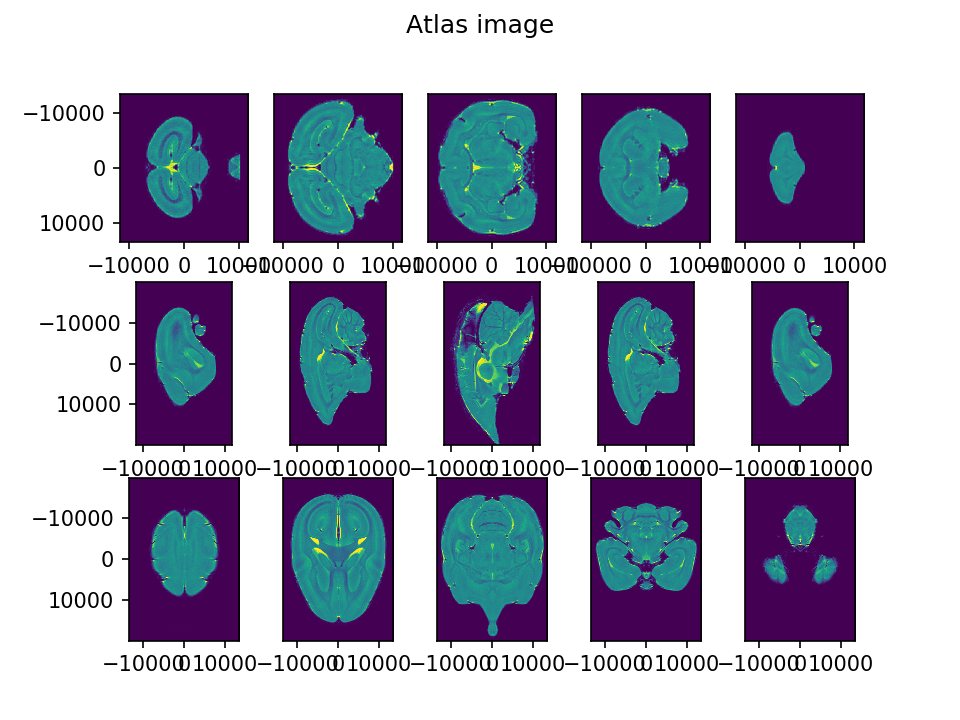

Found extension .nii
Opening with nibabel, note only 3D images supported
[349.99999404 349.99999404 699.99998808]


<IPython.core.display.Javascript object>


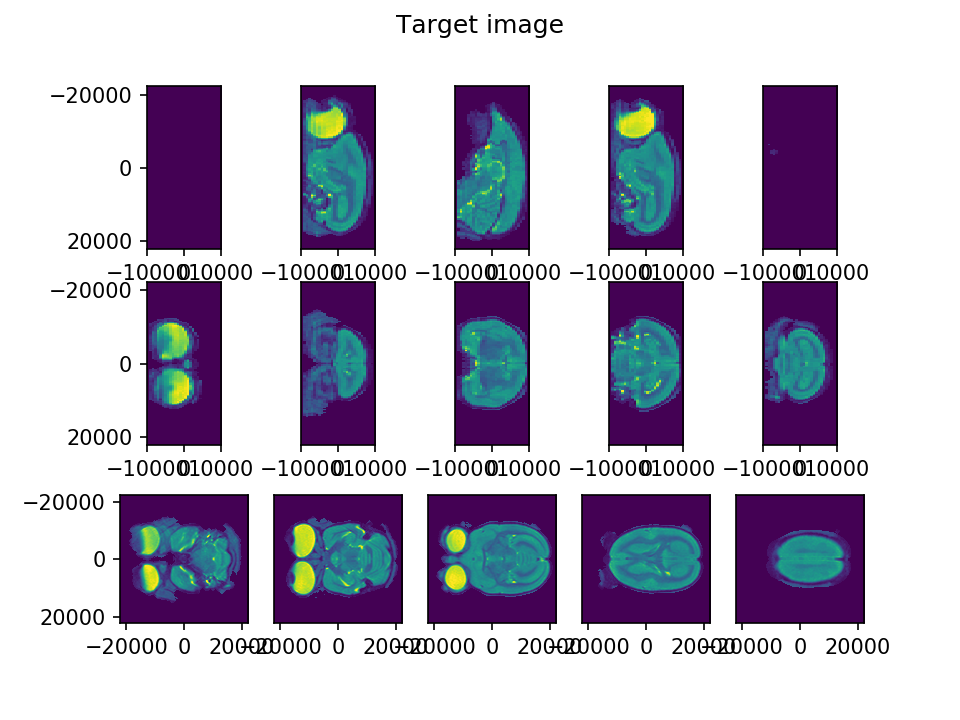

starting to compose sequence with transforms ricardo_nii_test/


<IPython.core.display.Javascript object>


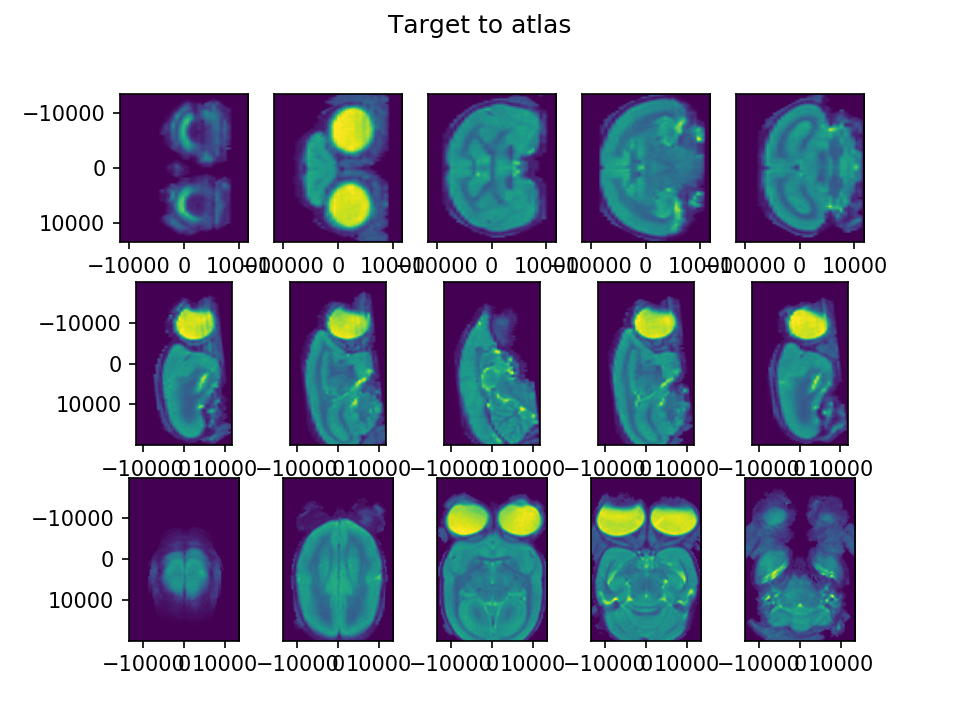

Found extension .nii
Found extension .nii
Opening with nibabel, note only 3D images supported
[349.99999404 349.99999404 699.99998808]


<IPython.core.display.Javascript object>


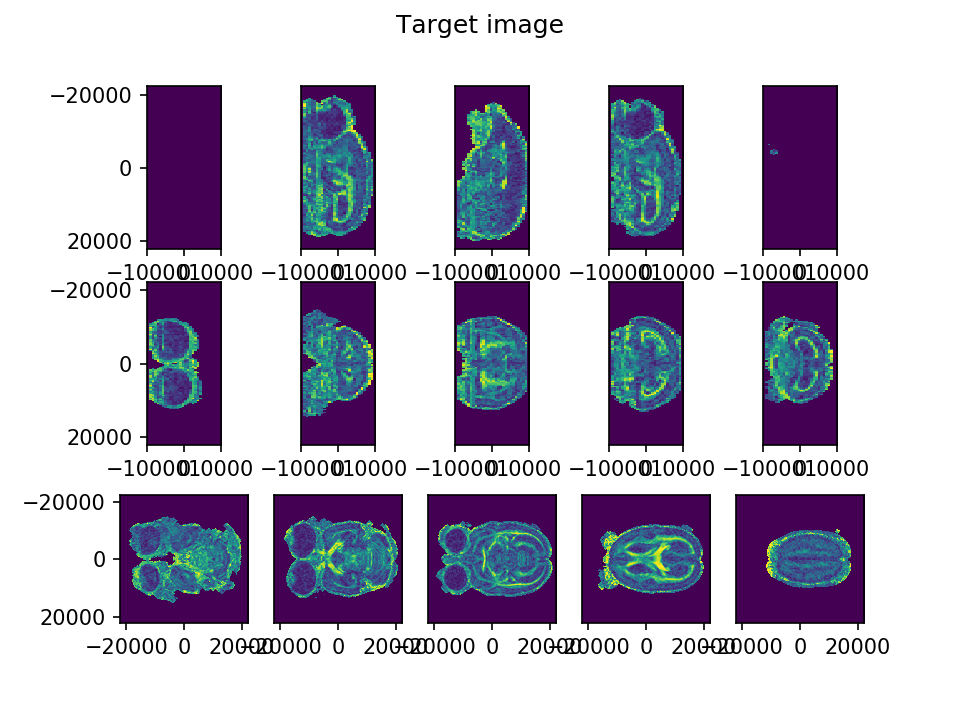

starting to compose sequence with transforms ricardo_nii_test/


<IPython.core.display.Javascript object>


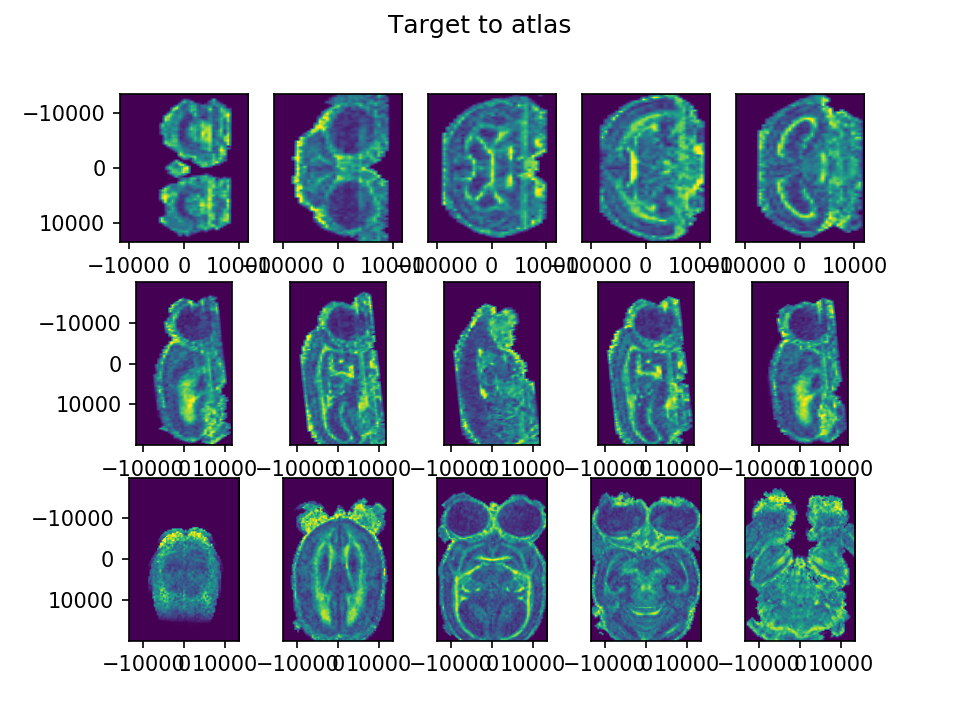

Found extension .nii
Found extension .nii
Opening with nibabel, note only 3D images supported
[269.66291666 269.66291666 539.58332539]


<IPython.core.display.Javascript object>


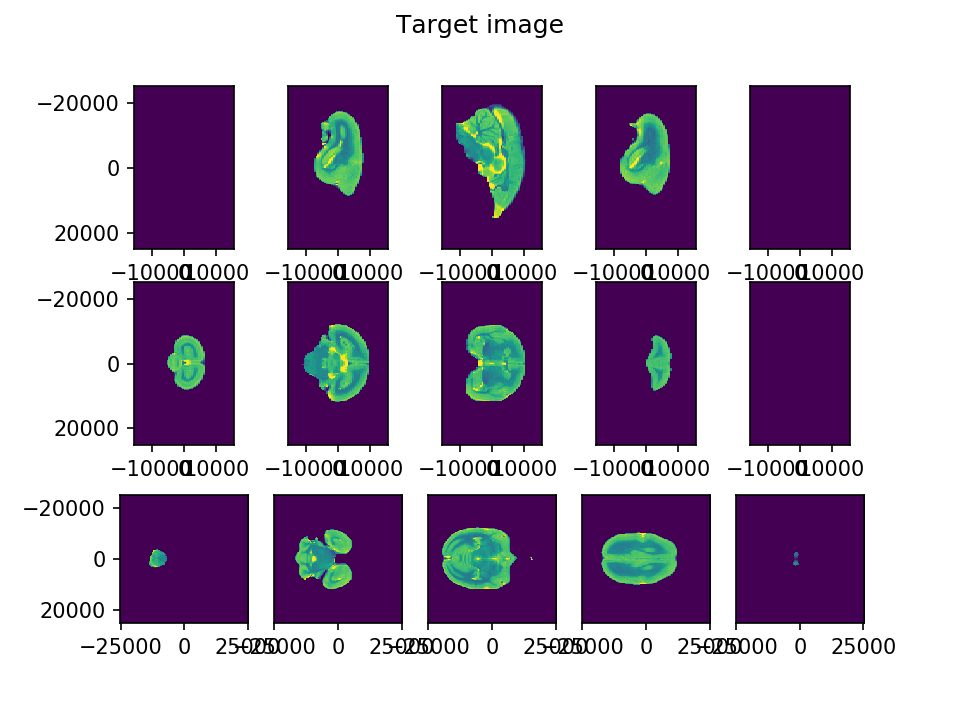

starting to compose sequence with transforms ricardo_nii_test/


<IPython.core.display.Javascript object>


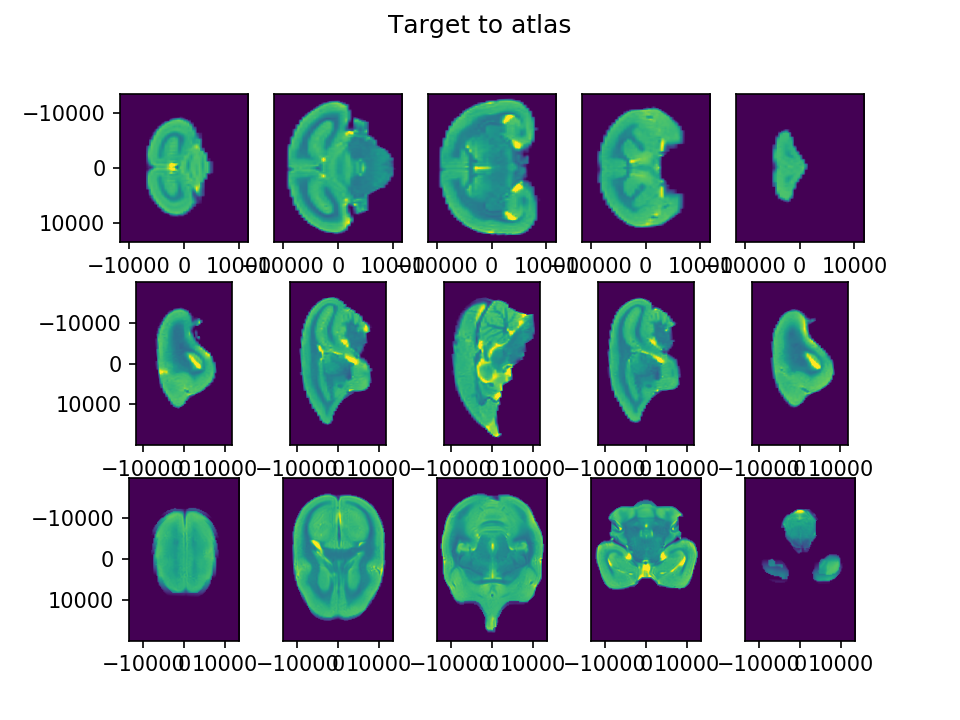

Found extension .nii


In [24]:
# reload atlas at full res 
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')

# transform target images at full res
for fname in targets_to_transform_names:
    xJ,J,title,names = emlddmm.read_data(fname)
    J = J.astype(float)
    J /= np.mean(np.abs(J))
    xJ = [x*target_voxel_scale_factor for x in xJ]
    dJ = np.array([x[1]-x[0] for x in xJ])
    print(dJ)
    J = J.astype(float)#**0.25
    fig = emlddmm.draw(J,xJ)
    fig[0].suptitle('Target image')
    fig[0].canvas.draw()
    
    Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
    Xout = emlddmm.compose_sequence(output_dir,Xin)
    Jt = emlddmm.apply_transform_float(xJ,J,Xout)

    fig = emlddmm.draw(Jt,xI)
    fig[0].suptitle('Target to atlas')
    fig[0].canvas.draw()
    
    # write out
    outname = os.path.splitext(os.path.split(fname)[1])[0]
    outname = os.path.join(atlas_output_dir,outname+ext)
    emlddmm.write_data(outname,xI,Jt,'target_to_atlas')

In [ ]:
# note